# Introduction

**Contents:**

1. Introduces the `GEModelTools`
1. Solves and simulates a simple **Heterogenous Agent Neo-Classical (HANC) model**

In [2]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANCModel import HANCModelClass

### New model

1. Households: Solve
\begin{align*}
v_{t}(z_{t},a_{t-1})	& =\max_{c_{t}}\frac{c_{t}^{1-\sigma}}{1-\sigma}+\beta\mathbb{E}_{t}\left[v_{t+1}(z_{t+1},a_{t})\right] \\
\text{s.t. }a_{t}+c_{t}	& =(1+r_{t})a_{t-1}+(1-\tau_{t})z_{t}\geq0 \\
\log z_{t+1}	&=\rho_{z}\log z_{t}+\psi_{t+1}\,\,\,,\psi_{t}\sim\mathcal{N}(\mu_{\psi},\sigma_{\psi}),\,\mathbb{E}[z_{t}]=1
\end{align*}
where $r_{t}$ is the real-interest rate and $\tau_{t}$ is a tax rate
2. Government: Set taxes and government bonds follows 
\begin{align*} 
B_{t+1}=(1+r_{t})B_{t}-\int\tau_{t}z_{t}d\boldsymbol{D}_{t} 
\end{align*}

3. Bond market clearing: $B_{t}=\int a_{t}^{\ast}(z_{t},a_{t-1})d\boldsymbol{D}_{t}$

4. Define and find the stationary equilibrium

\begin{align*}
B_{t+1}=(1+r_{t})B_{t}-\int\tau_{t}z_{t}d\boldsymbol{D}_{t} \\
\Rightarrow B_{ss}=(1+r_{ss})B_{ss}-\int\tau_{t}z_{t}d\boldsymbol{D}_{ss} \\
\Leftrightarrow r_{ss}=\frac{1}{B_{ss}}\int\tau_{t}z_{t}d\boldsymbol{D}_{ss}
\end{align*}

\begin{align*}
H_{ss}\left(B_{ss}; \tau_{ss}\right)=
\left[ 
    \begin{matrix}
B_{ss}-\boldsymbol{a}_{ss}^{\ast\prime}\boldsymbol{D}_{ss} \\
r_{ss}-\frac{1}{B_{ss}}\int\tau_{ss}z_{t}d\boldsymbol{D}_{ss} \\
\boldsymbol{D}_{ss}-\Pi_{z}^{\prime}\underline{\boldsymbol{D}}_{ss} \\
\underline{\boldsymbol{D}}_{ss}-\Lambda_{ss}^{\prime}\boldsymbol{D}_{ss}
\end{matrix} 
\right] =\boldsymbol{0}
\end{align*}
With Policy function: $a_{t}^{\ast}=a^{\ast}\left(\left\{ r_{\tau},\tau_{ss}\right\} _{\tau\geq t}\right)$

And Choice transition: $\Lambda_{t}=\Lambda\left(\left\{ r_{\tau},\tau_{ss}\right\} _{\tau\geq t}\right)$

You can also back out tau:
\begin{align*}
\Leftrightarrow \tau_{ss} = \frac{r_{ss}B_{ss}}{\int z_{t}d\boldsymbol{D}_{ss}}
\end{align*}
But because it part of the household problem we cannot use the indirect solution method 

# Setup

In [3]:
model = HANCModelClass(name='bonds') # create an instance of the model

In [4]:
par = model.par
ss = model.ss

**Pause:** Take a look at `.par` and `.ss`

**Question I:** Where does the variable names in `.ss` come from?

**Question II:** What explains the shapes below?

In [5]:
print(ss.a.shape)
print(ss.Dz.shape)
print(ss.D.shape)

(1, 7, 500)
(1, 7)
(1, 7, 500)


# Solve household problem

Set the steady state values, which matter for the household:

In [6]:
par.tau = 0.1
model.allocate()

In [7]:
ss.r = 0.02
#ss.w = 1.00

**Solve the household problem** with `.solve_hh_ss()`:
    
1. Calls `.prepare_hh_ss()`
1. Calls `.solve_backwards_hh()` until convergence

In [8]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 2.3 secs [274 iterations]


In [9]:
model.ss.Dbeg

array([[[0.015625, 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.09375 , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.234375, 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        ...,
        [0.234375, 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.09375 , 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ],
        [0.015625, 0.      , 0.      , ..., 0.      , 0.      ,
         0.      ]]])

In [10]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 2.8 secs [196 iterations]


**Aggregate savings:**

In [11]:
np.sum(ss.a*ss.D)

1.1118710344266713

# Find stationary equilibrium

## Direct approach

In [12]:
model.find_ss(method='direct',do_print=True)
# Different range needs to be searced for large tau e.g. tau =0.5
#model.find_ss(method='direct',do_print=True,K_min =10., K_max=100.)

### step 1: broad search ###

guess ss.B = 0.0100
implied ss.r = 10.0000
household problem in ss solved in 0.0 secs [20 iterations]
household problem in ss simulated in 0.0 secs [8 iterations]
implied ss.A_hh = 325.1640
clearing_A = 325.15399930

guess ss.B = 0.2624
implied ss.r = 0.3811
household problem in ss solved in 0.0 secs [108 iterations]
household problem in ss simulated in 0.0 secs [36 iterations]
implied ss.A_hh = 115.5020
clearing_A = 115.23954216

guess ss.B = 0.5148
implied ss.r = 0.1942
household problem in ss solved in 0.1 secs [171 iterations]
household problem in ss simulated in 0.0 secs [66 iterations]
implied ss.A_hh = 107.4012
clearing_A = 106.88632812

guess ss.B = 0.7673
implied ss.r = 0.1303
household problem in ss solved in 0.1 secs [222 iterations]
household problem in ss simulated in 0.0 secs [106 iterations]
implied ss.A_hh = 104.4582
clearing_A = 103.69093272

guess ss.B = 1.0197
implied ss.r = 0.0981
household problem in ss solved in 0.1 secs [264 iteratio

**Look at the steady state variables:**

In [13]:
for varname in model.varlist:
    print(f'{varname:15s}: {ss.__dict__[varname]:.4f}')

Y              : 1.0000
C              : 1.0000
I              : 0.0000
B              : 3.3734
r              : 0.0296
A_hh           : 3.3734
C_hh           : 0.9999
clearing_A     : -0.0000
clearing_C     : -0.0001


## Looking at the stationary equilibrium

### Policy functions

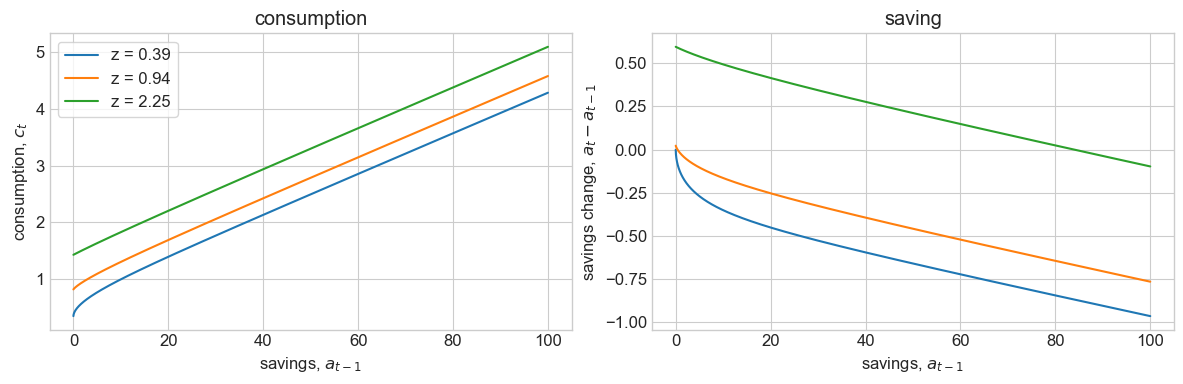

In [14]:
fig = plt.figure(figsize=(12,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,2,1)
ax.set_title(f'consumption')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'z = {z:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(1,2,2)
ax.set_title(f'saving')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],ss.a[0,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

fig.tight_layout()

### Distributions

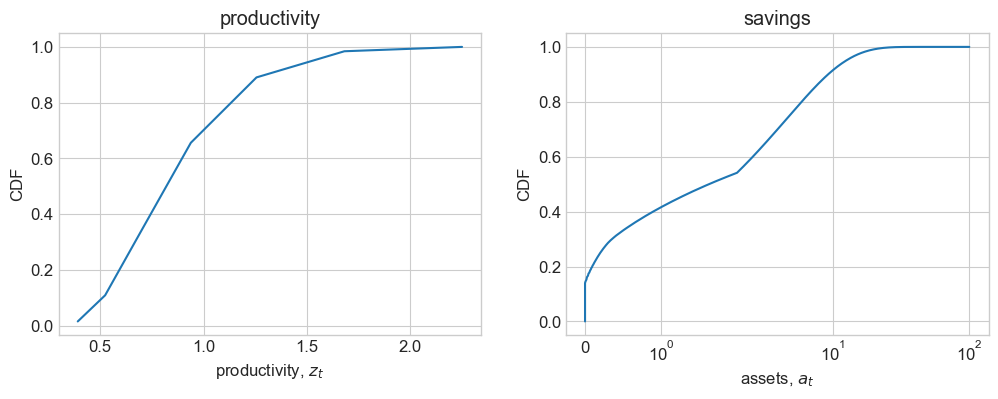

In [15]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
ax.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

**Income moments:**

In [16]:
mean_z = np.sum(ss.D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(ss.D*(par.z_grid[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.36


**Asset moments:**

In [17]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a:  3.373
p25  a:  0.201
p50  a:  1.631
p95  a: 12.541
p99  a: 19.575
std. a:  4.419


**MPC:**

In [18]:
def calc_MPC(par,ss):
    
    MPC = np.zeros(ss.D.shape)
    dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
    dm = (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
    MPC[:,:,:-1] = dc/dm
    MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
    mean_MPC = np.sum(MPC*ss.D)
    return mean_MPC

mean_MPC = calc_MPC(par,ss)
print(f'mean MPC: {mean_MPC:.3f}')

mean MPC: 0.193


**Question:** What is the correlation between income and savings?

## Indirect approach

In [19]:
# Indirect approach does not work
#model_indirect = model.copy()
#model_indirect.r_ss_target = 0.1
#model_indirect.allocate()

In [20]:
#model_indirect.find_ss(method='indirect',do_print=True)

**Question:** What are the pros and cons of the direct and indirect method?

# Idiosyncratic risk and the steady state interest rate

In [21]:
print(f'ss.A_hh = ss.K = {ss.A_hh:.2f}')
print(f'ss.r = {ss.r*100:.2f} %')
print('')
      
for sigma_psi in np.linspace(par.sigma_psi,2*par.sigma_psi,5):
    
    print(f'{sigma_psi = :.2f}')

    model_ = model.copy()
    model_.par.sigma_psi = sigma_psi
        
    model_.solve_hh_ss(do_print=False)
    model_.simulate_hh_ss(do_print=False)
    
    A_hh = np.sum(model_.ss.a*model_.ss.D)
    
    print(f'PE {A_hh = :.2f}')
          
    model_.find_ss(method='direct')

    print(f'GE ss.r = {model_.ss.r*100:.2f} %')
    print(f'GE ss.A_hh = ss.K = {model_.ss.A_hh:.2f}')

    print('')

ss.A_hh = ss.K = 3.37
ss.r = 2.96 %

sigma_psi = 0.10
PE A_hh = 3.37
GE ss.r = 2.96 %
GE ss.A_hh = ss.K = 3.37

sigma_psi = 0.12
PE A_hh = 6.10
GE ss.r = 2.54 %
GE ss.A_hh = ss.K = 3.94

sigma_psi = 0.15
PE A_hh = 9.34
GE ss.r = 2.15 %
GE ss.A_hh = ss.K = 4.66

sigma_psi = 0.18
PE A_hh = 12.86
GE ss.r = 1.80 %
GE ss.A_hh = ss.K = 5.55

sigma_psi = 0.20
PE A_hh = 16.46
GE ss.r = 1.52 %
GE ss.A_hh = ss.K = 6.59



# Calibration

In [22]:
from root_finding import brentq

In [23]:
def calib_obj(beta,model):
    """ calibration objective """
    
    model.par.beta = beta
    model.find_ss(method='direct')    
    
    mean_MPC = calc_MPC(model.par,model.ss)
     
    return mean_MPC-0.20

In [24]:
model_calib = model.copy()
brentq(calib_obj,0.94,par.beta,args=(model_calib,),do_print=True,varname='beta',funcname='MPC-0.20');

  0: beta =   0.95800510 -> MPC-0.20 =   0.00075324
  1: beta =   0.95821154 -> MPC-0.20 =   0.00000942
  2: beta =   0.95821416 -> MPC-0.20 =   0.00000000
  3: beta =   0.95821416 -> MPC-0.20 =  -0.00000003

beta =   0.95821416 [MPC-0.20 =   0.00000000]



In [25]:
print(f'ss.r = {model_calib.ss.r*100:.2f} %')
print(f'ss.B = {model_calib.ss.B:.2f}')

ss.r = 3.12 %
ss.B = 3.21


**Question:** What could be an alternative be to use a root-finder?

# Exercise

1. What is the optimal level of of $\tau_t$

In [26]:
model.ss.c.shape

(1, 7, 500)

In [27]:
ss = model.ss


ss.c.shape

(1, 7, 500)

In [28]:
ss.D.shape

(1, 7, 500)

In [29]:
def util(c,par):
    return c**(1-par.sigma)/(1-par.sigma)

def wellfare(model,type='benthamite'):
    ss = model.ss
    par = model.par

    U = util(ss.c,par)
    #Da = np.sum(ss.D,axis=(0,1))

    # Social welfare functions: https://en.wikipedia.org/wiki/Social_welfare_function
    if type.lower() in ['benthamite','sum']:
        
        
        W = np.sum(ss.D*U)
    

    if type.lower() in ['semi-rawls']:
        
        pass
        #W = percentile(par,Da_cs,0.1,var='c')

    return W

In [30]:
wellfare(model)

-1.1332638407719835

In [31]:
def obj_fun(tau,model):
    model.par.tau = tau
    model.find_ss(method='direct')    
    W = wellfare(model)
    return -W

In [34]:
model.ss.r

0.029643365948282308

In [35]:
tau_list = np.linspace(0,0.5,10)


In [36]:
model_calib = model.copy()
W_list = np.empty(tau_list.shape)

for i, tau in enumerate(tau_list):
    print(f'Tau = {tau:.3f}')

    W = obj_fun(tau,model_calib)
    W_list[i] = W

    print(f'W = {W:.4f}')
    print(f'B = {model_calib.ss.B}')
    print('')


#W_list = [obj_fun(tau,model_calib) for tau in tau_list]
#W_list

Tau = 0.000
W = 1.1320
B = 0.17342576239566684

Tau = 0.056
W = 1.1287
B = 2.1652376615370903

Tau = 0.111
W = 1.1347
B = 3.6615117162250215

Tau = 0.167
W = 1.1427
B = 5.052139162208283

Tau = 0.222
W = 1.1519
B = 6.387421545488851

Tau = 0.278
W = 1.1615
B = 7.6869772091373125

Tau = 0.333
W = 1.1715
B = 8.961066089198834

Tau = 0.389
W = 1.1813
B = 10.215599585761657

Tau = 0.444
W = 1.1909
B = 11.453890799652896

Tau = 0.500
W = 1.2001
B = 12.677025012090075



In [ ]:
model_calib.par.tau = 0.8
model_calib.find_ss(method='direct',do_print=True) 

### step 1: broad search ###

guess ss.B = 0.0100
implied ss.r = 80.0000
household problem in ss solved in 0.0 secs [12 iterations]
household problem in ss simulated in 0.0 secs [7 iterations]
implied ss.A_hh = 881.8359
clearing_A = 881.82585280

guess ss.B = 0.2624
implied ss.r = 3.0485
household problem in ss solved in 0.0 secs [32 iterations]
household problem in ss simulated in 0.0 secs [14 iterations]
implied ss.A_hh = 197.2073
clearing_A = 196.94488177

guess ss.B = 0.5148
implied ss.r = 1.5539
household problem in ss solved in 0.0 secs [45 iterations]
household problem in ss simulated in 0.0 secs [19 iterations]
implied ss.A_hh = 156.6519
clearing_A = 156.13706033

guess ss.B = 0.7673
implied ss.r = 1.0427
household problem in ss solved in 0.0 secs [56 iterations]
household problem in ss simulated in 0.0 secs [23 iterations]
implied ss.A_hh = 140.1106
clearing_A = 139.34336678

guess ss.B = 1.0197
implied ss.r = 0.7845
household problem in ss solved in 0.0 secs [67 iterations]
h

In [ ]:
model_calib.par.tau = 0.9
model_calib.find_ss(method='direct',do_print=True) 

### step 1: broad search ###

guess ss.B = 0.0100
implied ss.r = 90.0000
household problem in ss solved in 0.0 secs [12 iterations]
household problem in ss simulated in 0.0 secs [7 iterations]
implied ss.A_hh = 934.6750
clearing_A = 934.66498971

guess ss.B = 0.2624
implied ss.r = 3.4296
household problem in ss solved in 0.0 secs [30 iterations]
household problem in ss simulated in 0.0 secs [14 iterations]
implied ss.A_hh = 206.2439
clearing_A = 205.98151194

guess ss.B = 0.5148
implied ss.r = 1.7481
household problem in ss solved in 0.0 secs [42 iterations]
household problem in ss simulated in 0.0 secs [19 iterations]
implied ss.A_hh = 162.4600
clearing_A = 161.94510911

guess ss.B = 0.7673
implied ss.r = 1.1730
household problem in ss solved in 0.0 secs [52 iterations]
household problem in ss simulated in 0.0 secs [24 iterations]
implied ss.A_hh = 144.4701
clearing_A = 143.70281737

guess ss.B = 1.0197
implied ss.r = 0.8826
household problem in ss solved in 0.0 secs [62 iterations]
h

In [40]:
res = optimize.minimize_scalar(obj_fun,bounds=[0.05,0.15],args=(model_calib,),method='Bounded')
res

     fun: 1.1283004003204304
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 0.05000661069613519

In [36]:
tau_list = np.linspace(0,0.95,100)
model_calib = model.copy()
W_list = np.empty(tau_list.shape)

for i, tau in enumerate(tau_list):
    W = obj_fun(tau,model_calib)
    W_list[i] = -W


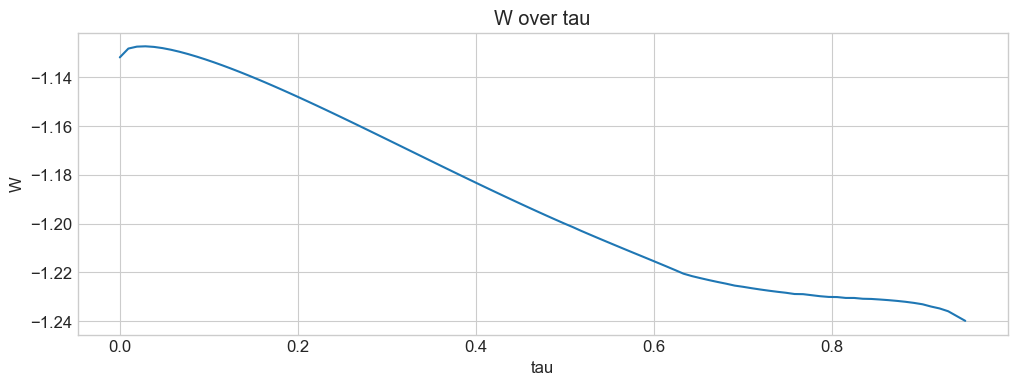

In [45]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,1,1)
ax.set_title('W over tau')
ax.plot(tau_list,W_list)

ax.set_xlabel('tau')
ax.set_ylabel('W');
